In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 1: GP regression to a simple dataset

In this tutorial we will model a very simple dataset (taken from the excellent *<a href="https://arxiv.org/pdf/1505.02965.pdf">Gaussian Processes for Regression:
A Quick Introduction<\aref>* by Mike Ebden) with a GP using a squared exponential covariance function.

The dataset consists of 6 observations, taken at inputs:
$$
\mathbf{x} = (−1.50, −1.00, −0.75, −0.40, −0.25, 0.00).
$$
The corrsponding, measured output values are:
$$
\mathbf{y} = (−1.70, −1.10, −0.3, 0.25, 0.60, 0.90).
$$
and all have measurement uncertainty $\sigma=0.3.$.

The goal of the exercise is to fit the data using a simple GP model, and to use that model to predict the observable $y_*$ at $x_*=0.4$.

## 1.0 Evaluate and plot the data

Use the cell below to evaluate $\mathbf{x}$ and $\mathbf{y}$ as `numpy` arrays and plot them.

<ErrorbarContainer object of 3 artists>

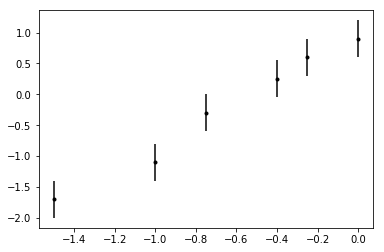

In [8]:
x = np.array([-1.50, -1.00, -0.75, -0.40, -0.25, 0.00])
y = np.array([-1.70, -1.10, -0.3, 0.25, 0.60, 0.90])
sig = 0.3
plt.errorbar(x,y,yerr=sig,fmt='k.')

## 1.1: Evaluate the covariance matrix

To model the data using a GP we need to select a covariance function. The data look like they follow a fairly simple smooth trend, so the squared exponential kernel, which is one of the simplest and most widely used, is a reasonable choice. It is given by:
$$
k_{\rm SE}(x,x') = A \exp \left[ - \Gamma (x-x')^2 \right]
$$
where $A$ is the variance and $\Gamma$ the inverse length scale. This kernel gives rise to smoothly varying, infinitely differentiable functions.

In the cell below, define a function `SEKernel` that computes the covariance matrix for the above kernel function. The function should take three mandatory arguments: an array containing the hyper-parameters of the covariance function ($A$ and $\Gamma$ in the equation above), and two arrays of input values. The function returns a 2-D array with shape $(N, M)$, where $N$ and $M$ are the numbers of inputs in each of the input arrays.

*Hint: you may find the function `cdist` from the module `scipy.spatial.distance` useful to evaluate a 2-D array of squared distances between the inputs. However, note that it expects input arrays of shape $(N,D)$ where $D$ is the number of dimensions of the inputs.*

In [9]:
from scipy.spatial.distance import cdist
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)

Now we need to test this function and see if it does what we want. In the absence of prior information on $A$ and $\Gamma$, let's set them both to unity for now.

In the cell below, generate a set of $30$ one-dimensional inputs regularly spaced between -2 and 1 and store them in a variable called `xtest`, then compute the covariance matrix for these inputs, for $A=\Gamma=1$. Store the results in a variable called `Ktest`, and display it using `matplotlib`'s `imshow` function.

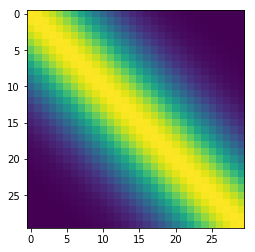

In [10]:
xtest = np.linspace(-2,1,30)
Ktest = SEKernel([1.0,1.0],xtest,xtest)
plt.imshow(Ktest,interpolation='none');

## 1.2 Draw samples from the prior

As discussed in the lectures, the choice of covariance function and hyper-parameters sets up a probability distribution over functions. But do the functions allowed by this specific choice look reasonable given the data? To answer that question, we will ***draw samples from the the GP prior***.

In the cell below, draw 5 samples from the distribution set up by `Ktest` and plot them alongside the data. You should assume that the mean of the GP is zero everywhere.

*Hint:* You may find the function `multivariate_normal` from the module `numpy.random` useful.

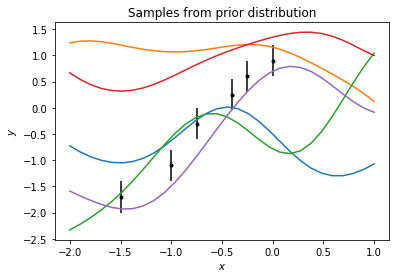

In [11]:
from numpy.random import multivariate_normal
plt.errorbar(x,y,yerr=sig,fmt='k.')
samples = multivariate_normal(np.zeros(len(xtest)),Ktest,5)
plt.plot(xtest,samples.T)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Samples from prior distribution');

## 1.3 Evaluating the likelihood

By eye, the samples from the prior look like a reasonable match to the data, in the sense that they display roughtly the right amplitude, length scale and degree of smoothness. To quantify this properly, we need to write  a function to evaluate the likelihood.

Under a GP model, the likelihood is simply a multivariate Gaussian with mean vector $\mathbf{m}$ and covariance matrix $K$:
$$
p(\mathbf{y} \mid \mathbf{m}, \mathbf{K}) = \mathcal{N}(\mathbf{m},\mathbf{K}).
$$
Assuming the mean function is zero everywhere for now (we will add non-trivial mean functions later), the negative log likelihood is then:
$$
\mathrm{NLL} = - \log \mathrm{p}(\mathbf{y}\mid \mathbf{m},\mathbf{K}) = \frac{1}{2} \mathbf{y}^{\mathrm{T}} \,
\mathbf{K}^{-1} \, \mathbf{y} + \frac{1}{2} \log |\mathbf{K}| + \frac{N}{2} \log 2 \pi
$$
where $N$ is the number of observations.

As discussed in the lectures, any white noise from observational uncertainties must be added to the diagonal elements of the covariance matrix.

Complete the definition of the function `GP_loglike` below. The function should evaluate the covariance matrix and return the log likelihood as given by the above equation. The first argument, `p`, contains the parameters of the covariance function, whose name is passed in the second argument, `CovFunc`. The remaining arguments should be self-explanatory. 

*Hint: Use `numpy.dot` and `numpy.linalg.inv` to do the matrix algrebra. You will also need to evaluate the log of the determinant of the covariance matrix, for this you can use `numpy.linalg.slogdet`. These functions particularly stable or efficient, but code optimisation is not the point of this tutorial. In tutorial 2 we will look at some ready-made GP packages, which use much more optimized matrix inversion techniques.** 

In [20]:
from numpy.linalg import inv
from numpy.linalg import slogdet
def GP_loglike(p,CovFunc,x,y,sig):
    # Evaluate the covariance matrix
    K = CovFunc(p,x,x)
    # Add the white noise term
    K += np.identity(x.shape[0]) * e**2
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = -0.5 * np.dot(y,np.dot(Ki,y))
    term2 = -0.5 * slogdet(K)[1]
    term3 = -0.5 * len(y) * np.log(2*np.pi)
    # return the total
    return term1 + term2 + term3

Now let's evaluate the log likelihood for our initial guess of hyper-parameters, $A=\Gamma=1$.

In [15]:
par_init = np.array([1.0,1.0])
LL_init = GP_loglike(par_init, SEKernel, x, y, sig)
print(LL_init)

-4.5933086846223645


## 1.4 Fitting for the hyper-parameters

This looks like a low number, but in isolation, the log likelihood value doesn't tell us much. Can we find a better set of hyper-parameters? To do this we must maximise the (log) likelihood with respect to the hyper-parameters. Use the next cell to do this.

*HInt: We can use `fmin` from the `scipy.optimize` module, but this works by minimizing a function, so we first need to write a wrapper around our log likelihood function that will return the negative log likelihood.

In [17]:
from scipy.optimize import fmin
def GP_negloglike(p,CovFunc,x,y,e):
    return -GP_loglike(p,CovFunc,x,y,e)
par_ML = fmin(GP_negloglike,par_init,args=(SEKernel, x, y, sig))
print(par_ML)

Optimization terminated successfully.
         Current function value: 4.364700
         Iterations: 41
         Function evaluations: 78
[1.90103594 0.46087476]


Ok, so we now have a new set of hyper-parameters that give a (slightly) improved log likelihood. We are ready to start making ***predictions***.

## 1.5 Single-point prediction

As we saw in the lecture, the posterior distribution (also called the conditional or predictive distribution) for $y$ evaluated at test input $x_*$, given the observations, is a multivariate Gaussian with mean and variance
$$
\begin{array}{lll}
\mathbb{E}[y_*] \equiv \overline{y_*} & = & \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{y}, \\
\mathbb{V}[y_*] & = & k(x_*,x_*,\boldsymbol{\phi}) - \mathbf{k}_*^{\rm T} \, (\mathbf{K} + \sigma^2 \mathbb{I})^{-1} \, \mathbf{k}_*,
\end{array}
$$
where $\mathbf{k}_*$ is the vector of covariances between the test point and the training points, such that $k_{*,i}=k(x_i,x_*)$.

Use the equations above to evaluate the predictive mean and variance at $x_*=0.4$, given the best-fit hyper-parameters, and plot them together with the observed data.

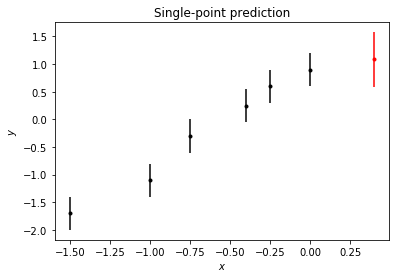

In [34]:
K = SEKernel(par_ML,x,x) + np.identity(len(x)) * sig**2
Ki = inv(K)
x_star = np.array([0.4])
ks = SEKernel(par_ML,x_star,x)
y_star = np.dot(ks, np.dot(Ki, y))
kss = SEKernel(par_ML,x_star,x_star)
var_star = kss - np.dot(ks, np.dot(Ki, ks.T))
sig_star = np.sqrt(var_star)
plt.errorbar(x,y,yerr=sig,fmt='k.')
plt.errorbar(x_star,y_star,yerr=sig_star,fmt='r.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Single-point prediction');

## 1.6 The predictive distribution

But of course the GP_predict function allows us to make predictions for *any* inputs. In the cell below, complete the definition of the function `GP_predict`, computes and returns the mean and covariance of the predictive distribution for a given covariance function, with associated parameters, a given set of observations $(\mathbf{x},\mathbf{y},\mathbf{\sigma})$, where $\mathbf{\sigma}$ are the uncertainties associated with each observation, at a given set of test inputs $\mathbf{x}_*$. 

In the following cell, evaluate and plot the mean and 95\% confidence interval of the predictive distribution for 100 regularly spaced test points between -3 and 3.

*Hint: the variance $\sigma^2$ of the distribution is given by the diagonal elements of the covariance matrix, and the 95% confidence interval is bounded by the mean plus or minus 2 $\sigma$. You can us the `matplotlib` function `fill_between` to shade the area within the 95% confidence interval.*

In [35]:
def Pred_GP(CovFunc, CovPar, x, y, sig, x_star):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, x, x) 
    # add white noise
    K += np.identity(x.shape[0]) * sig**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, x_star, x_star)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, x_star, x)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, y))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

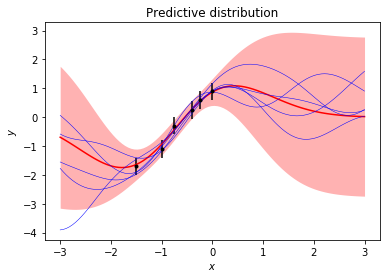

In [36]:
plt.errorbar(x,y,yerr=sig,fmt='k.')
x_star = np.linspace(-3,3,100)
y_star,cov_star = Pred_GP(SEKernel,par_ML,x,y,sig,x_star)
sig_star = np.sqrt(np.diag(cov_star))
plt.plot(x_star,y_star,'r-')
plt.fill_between(x_star, y_star + 2 * sig_star, y_star - 2 * sig_star, color = 'r', lw=0, alpha=0.3)
samples = multivariate_normal(y_star,cov_star,5).T
plt.plot(x_star,samples,'b-',lw=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');


Some things to note:
- while the prior distribution is stationary (the mean and variance are constant over the input range) the predictive distribution is not;
- far away grom observations, the predictive distribution returns to the prior
- where observations are close together compared to the lenght scale of the GP, the predictive ability is good: the 95% confidence interval is narrow and the samples from the predictive distribution all behave similarly
- the predictive mean doesn't have the same behaviour as the samples from the predictive distribution: the samples are more "wiggly".

# <font color=red>DONE TILL HERE</font>

### Problem 3a: Including a mean function

This dataset contains a linear trend as well as correlated noise. We want leanr the trend at the same time as the noise, so we need to define a mean function 

Complete the definition of the mean function below, so that it evaluates abd return $f = p[0] x + p[1]$. Check that it works by plotting its output on top of the data above, taking the parameter values from the code that generated the data.

In [ ]:
def LinearMean(p,x):
    return # complete
pm0 = [0.03, -0.3]
m = # complete
plt.errorbar(xobs,yobs,yerr=eobs,fmt='k.',capsize=0)
plt.plot(xobs,m,'r-')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

### Problem 3b: Likelihood with a mean function

Evaluating the likelihood of a GP with a non-zero mean function is easy: simply evaluate the mean vector, subtract it from the data, and compute the likelihood as before, but using the residuals rather than the original data. 

Modify the likelihood function you defined earlier so that it does this. Check that it runs ok by calling it once on the dataset, using guesses for the values of the parameters.

*Hint: use optional keyword arguments so that your likelihood function still works without a mean function. You will also need to tell the likelihood function how many of the parameters belong to the mean function.*

In [ ]:
def NLL_GP2(p,CovFunc,x,y,e, MeanFunc=None, nmp = 0):
    if MeanFunc:
        pc = p[# complete
        pm = p[# complete
        r = y - # complete
    else:
        pc = p[:]
        r = y[:]
    # Evaluate the covariance matrix
    K = # complete
    # Add the white noise term
    K += # complete
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = # complete
    term2 = # complete
    term3 = # complete
    # return the total
    return term1 + term2 + term3

In [ ]:
p0 = [0.005,2.0,0.03,-0.3]
print(NLL_GP2# complete

Now you are ready to fit for all the hyper-parameters simultaneously: those of the covariance function, and those of the mean function. 


In [ ]:
p1 = fmin(# complete
print(p1)

**NB:** The fit can be quite sensitive to the initial guesses for the parameters. Therefore, you may find the fit converges to unexpected values unless you start fairly close to the "correct" ones. In the next tutorial, we will look at more robust ways of exploring the parameter space.

### Problem 3c: Including the mean function in the predictions

The simplest way to do this is to use the `LinearMean` function to evaluate the mean vector, and the `Pred_GP` function we wrote earlier to evaluate the stochastic component, and add the two together. 

Plot the data together with the mean and 95% confidence interval of the predictive distribution, using the best-fit hyper-parameters.

*Hint: you'll need to generate a new set of test inputs (the values at which you want to evaluate the predictive distribution) as our new dataset spans a wider range than the old one.*

In [ ]:
# Generate test inputs (values at which we ant to evaluate the predictive distribution)
x = np.linspace(# complete
# Evaluate mean function at observed inputs, and compute residuals
mobs = # complete
robs = yobs-mobs
# Evaluate stochastic component at test inputs
m,C = Pred_GP(# complete
# Evaluate mean function at test inputs
m += # complete
sig = # complete
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.plot(x,m,'k-')
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Maximum likelihood distribution');

**NB:** See how the predictive distribution continues the linear trend outside the range of hte data. If we had tried to model the same dataset without using a mean function, we might well have got a visually acceptable fit, but the predictive distribution would have returned to the prior rapidly outside the range of the data.

## Problem 4: Model comparison

One question that is frequently asked about GPs is how to chose the covariance function. There is no simple answer to this. The best starting point is domain knowledge, things you know about your dataset a priori. But if you are looking for an empirical way to compare different kernels for a given dataset, this is a standard model comparison problem.

Similarly, if you are using GPs as part of a detection problem, where you are asking whether the data contain a particular signal which is represented via the mean function, you might want to compare models with the same covariance function, but with and without a (non-zero) mean function. 

In both of the above examples, the number of hyper-parameters can vary between the models one is comparing, so model comparison is not straight forward. Ideally one would evaluate and compare the evidence for different kernels (i.e. the likelihood marginalised over the hyper-parameters), but doing this is outside the scope of the present tutorial. Therefore, here we will use a simple alternative, the Bayesian Information Criterion (BIC).

### Problem 4a: Comparing two covariance functions

Consider the dataset we simulated earlier, with the linear trend and the correlated noise. The correlated noise was generated using a squared exponential GP. If we didn't know this, would we be able to distinguish between a squared exponential and a different kind of covariance function?

To test this, let's try a changing the covariance function. We will use the Matern 3/2 kernel:
$$
k_{3/2} (x,x') = A \left[ 1 + \sqrt{3r^2} \right] \exp \left[ - \sqrt{3r^2} \right] 
$$
where $r^2=\Gamma(x-x')^2$. I picked this one for two reaons:
- This kernel gives rise to much rougher functions (which can only be differentiated once, compared to the smooth functions generated by the squared exponential kernel, which can be differentiated an infinite number of times), so in principle it should be easy to distinguish between the two kernels.
- The two kernels have the same number of parameters, so comparing the BIC's is equivalent to comparing the (maximum) likelihoods.

Start by defining a function `M32Kernel` with the same structure and calling sequence as `SEKernel`, but implementing the Matern 3/2 covariance function.

*Hint: use the `seuclidean` metric for `cdist`.*

In [ ]:
def M32Kernel(par, x1, x2):
    A, Gamma = par
    R = cdist(# complete
    return # complete

Now try fitting the data using the `LinearMean` mean function and the `M32Kernel` covariance function.

In [ ]:
p0 = [0.005,2.0,0.03,-0.3]
print(NLL_GP2(# complete
p1 = fmin(# complete
print(p1)
print(NLL_GP2(# complete

How does the best fit likelihood compare to what you obtained using the `SEKernel`? Which kernel would you adopt if you had to chose between the two. Write your answer in the cell below.

The maximum log likelihood in the case of the SEKernel was -93.25, compared to -89.55 for the `M32Kernel`, so the `SEKernel` is preferred, as one would expect, though the difference is not very large as far as these things go.

### Problem 4b: Mean, or no mean?

Now let us try comparing models with and without non-zero mean function. This time we are comparing models with different numbers of parameters, so we will need to evaluate the BIC rather than simply compare the likelihoods. The BIC is defined as:
$$
\mathrm {BIC} ={\ln(N)K-2\ln({\hat {L}})},
$$
where $N$ is the number of observations, $J$ is the number of parameters, and $\hat{L}$ refers to the likelihood maximised with respect to the parameters of the model.

Start by fitting the simulated dataset with a squared exponential kernel, with and without no mean function. Evaluate the maximum likelihood in each case and store it in variables `L_mean` and `L_no_mean`, respectively.

In [ ]:
# Copy and paste your answer to the previous problem and modify it as needed

Now evaluate the BIC in each case. Which model is preferred?

In [ ]:
N = len(xobs)
BIC_mean = # complete
print(BIC_mean)
BIC_no_mean = # complete
print(BIC_no_mean)

Thus the model with a non-zero mean function is strongly preferred (BIC differences $> 10$ are generally considered to represent very strong support for one model over the other).

How different would the predictive distributions and samples be? Try plotting them in each case.

In [ ]:
# Plot the data
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Model comparison')
# Evaluate and plot the predictive distribution with a mean function
mobs = # complete
robs = yobs-mobs
m,C = Pred_GP(# complete
m += # complete
sig = # complete
plt.plot(x,m,'b-')
plt.fill_between(x,m+2*sig,m-2*sig,color='b',alpha=0.2)
# Now do the same for the model without mean function
m,C = Pred_GP(# complete
sig = # complete
plt.plot(x,m,'r-')
plt.fill_between(x,m+2*sig,m-2*sig,color='r',alpha=0.2)

As you can see, the predictive distribution are essentially indistinguishable in regions where we have lots of data, but the predictive ability of the model without mean function is much poorer away from the data. Of course, this is as expected.

## Challenge problem: Kepler light curve of a spotted star



In this problem you will model the light curve of a spotted star observed by Kepler using a GP with a quasi-periodic covariance function. 

[McQuillan et al. (2014)](http://iopscience.iop.org/article/10.1088/0067-0049/211/2/24/) used a method based on the auto-correlation function of the light curve to measure the rotation periods of over 30000 Kepler main-sequence stars. I have selected one, KIC2157356, which shows a very clear modulation, and for which McQuillan et al. measured a period of $13.61 \pm 0.05$ days. 

You will find one year's worth of Kepler data for this star in [this file](file/KIC2157356.txt). The 4 columns are: time in days, relative flux, flux error, and quarter number. The Kepler satellite rotates about its pointing axis every 3 months to keep its solar panels oriented towards the Sun, and this leads to breaks in the observations, as well as baseline shifts. 

Your task is to read in the data and model it using the quasi-periodic covariance function:
$$
k_{\mathrm{QP}}(t,t') = A \exp \left[ - \Gamma_1 \sin^2 \left( \frac{\pi (t-t')}{P} \right) - \Gamma_2 (t-t')^2 \right]
$$
in order to evaluate the rotation period $P$. You should start by modelling each quarter separately, checking the consistency of your results on the different quarters. 

Then introduce a mean function to account for the baseline shifts between quarters, and fit for the 4 quarters simultaneously. This will also enable you to get a better estimate of the evolutionary timescale for the star spots that cause the flux variation, which is controlled by the parameter $\Gamma_2$. 

Can you think of a way to evaluate uncertainties on the period $P$?

**NB:** This is a much bigger dataset, even when considering only a single quarter. For the GP regression to run in reasonable time, you will probably need to **sub-sample** your data.